# Feature Engineering and Modelling

---

1. Import packages
2. Load data
3. Feature engineering
4. Modelling

---

## 1. Import packages

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

---
## 2. Load data

In [3]:
df = pd.read_csv('data/data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [4]:
df.head(3)

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,origin_up,pow_max,churn,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,2015-01-01,0.125976,0.103395,0.071536,40.565969,24.339581,16.226389
1,1,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,2015-02-01,0.125976,0.103395,0.071536,40.565969,24.339581,16.226389
2,2,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,2015-03-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383


---

## 3. Feature engineering

From EDA, we found that the churn and prices have weak correlations, therefore the correlation between churn and price is not the major driver. We need to engineer the feature differently to further investigate the relationship between price sensitivity and predicting churn. 

### Difference between off-peak prices in December and the preceding January


In [5]:
price_df = pd.read_csv('data/price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [6]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [7]:
df = pd.merge(df, diff, on='id')
df.head()

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,churn,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,1,2015-01-01,0.125976,0.103395,0.071536,40.565969,24.339581,16.226389,0.020057,3.700961
1,1,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,1,2015-02-01,0.125976,0.103395,0.071536,40.565969,24.339581,16.226389,0.020057,3.700961
2,2,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,1,2015-03-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383,0.020057,3.700961
3,3,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,1,2015-04-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383,0.020057,3.700961
4,4,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,1,2015-05-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383,0.020057,3.700961


---

### Average price changes across periods

We can now enhance the feature that our colleague made by calculating the average price changes across individual periods, instead of the entire year.

In [8]:
# Aggregate average prices per period by company
mean_prices = price_df.groupby(['id']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

In [9]:
# Calculate the mean difference between consecutive periods
mean_prices['off_peak_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_peak_var']
mean_prices['peak_mid_peak_var_mean_diff'] = mean_prices['price_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_mid_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_peak_fix']
mean_prices['peak_mid_peak_fix_mean_diff'] = mean_prices['price_peak_fix'] - mean_prices['price_mid_peak_fix']
mean_prices['off_peak_mid_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_mid_peak_fix']

In [10]:
columns = [
    'id', 
    'off_peak_peak_var_mean_diff',
    'peak_mid_peak_var_mean_diff', 
    'off_peak_mid_peak_var_mean_diff',
    'off_peak_peak_fix_mean_diff', 
    'peak_mid_peak_fix_mean_diff', 
    'off_peak_mid_peak_fix_mean_diff'
]
df = pd.merge(df, mean_prices[columns], on='id')
df.head()

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,price_peak_fix,price_mid_peak_fix,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,24.339581,16.226389,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.45067,26.040925
1,1,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,24.339581,16.226389,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.45067,26.040925
2,2,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,24.339578,16.226383,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.45067,26.040925
3,3,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,24.339578,16.226383,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.45067,26.040925
4,4,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,24.339578,16.226383,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.45067,26.040925


- This feature may be useful because it adds more granularity to the existing feature. Instead of looking at differences across an entire year, we have now created features that look at mean average price differences across different time periods (`off_peak`, `peak`, `mid_peak`).
- The dec-jan feature may reveal macro patterns that occur over an entire year, whereas inter-time-period features may reveal patterns on a micro scale between months.

---

### Max price changes across periods and months

Another way we can enhance the feature from our colleague is to look at the maximum change in prices across periods and months.

In [11]:
# Aggregate average prices per period by company
mean_prices_by_month = price_df.groupby(['id', 'price_date']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

In [12]:
# Calculate the mean difference between consecutive periods
mean_prices_by_month['off_peak_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_peak_var']
mean_prices_by_month['peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_peak_fix']
mean_prices_by_month['peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']
mean_prices_by_month['off_peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']

In [13]:
# Calculate the maximum monthly difference across time periods
max_diff_across_periods_months = mean_prices_by_month.groupby(['id']).agg({
    'off_peak_peak_var_mean_diff': 'max',
    'peak_mid_peak_var_mean_diff': 'max',
    'off_peak_mid_peak_var_mean_diff': 'max',
    'off_peak_peak_fix_mean_diff': 'max',
    'peak_mid_peak_fix_mean_diff': 'max',
    'off_peak_mid_peak_fix_mean_diff': 'max'
}).reset_index().rename(
    columns={
        'off_peak_peak_var_mean_diff': 'off_peak_peak_var_max_monthly_diff',
        'peak_mid_peak_var_mean_diff': 'peak_mid_peak_var_max_monthly_diff',
        'off_peak_mid_peak_var_mean_diff': 'off_peak_mid_peak_var_max_monthly_diff',
        'off_peak_peak_fix_mean_diff': 'off_peak_peak_fix_max_monthly_diff',
        'peak_mid_peak_fix_mean_diff': 'peak_mid_peak_fix_max_monthly_diff',
        'off_peak_mid_peak_fix_mean_diff': 'off_peak_mid_peak_fix_max_monthly_diff'
    }
)

In [14]:
columns = [
    'id',
    'off_peak_peak_var_max_monthly_diff',
    'peak_mid_peak_var_max_monthly_diff',
    'off_peak_mid_peak_var_max_monthly_diff',
    'off_peak_peak_fix_max_monthly_diff',
    'peak_mid_peak_fix_max_monthly_diff',
    'off_peak_mid_peak_fix_max_monthly_diff'
]

df = pd.merge(df, max_diff_across_periods_months[columns], on='id')
df.head()

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,0.058257,18.590255,7.45067,26.040925,0.06055,0.085483,0.146033,44.26693,8.145775,44.26693
1,1,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,0.058257,18.590255,7.45067,26.040925,0.06055,0.085483,0.146033,44.26693,8.145775,44.26693
2,2,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,0.058257,18.590255,7.45067,26.040925,0.06055,0.085483,0.146033,44.26693,8.145775,44.26693
3,3,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,0.058257,18.590255,7.45067,26.040925,0.06055,0.085483,0.146033,44.26693,8.145775,44.26693
4,4,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,0.058257,18.590255,7.45067,26.040925,0.06055,0.085483,0.146033,44.26693,8.145775,44.26693


The maximum price change between months and time periods would be a good feature to create because I was trying to think from the perspective of a PowerCo client. As a Utilities customer, a large increase in prices within a short time span would be an influencing factor in causing me to look at other utilities providers for a better deal. Since we are trying to predict churn for this use case, I thought this would be an interesting feature to include.

---

### Further feature engineering

This section covers extra feature engineering, as well as different ways to transform the data to account for some of its statistical properties, such as skewness.

### Tenure

How long a company has been a client of PowerCo.

In [15]:
df['tenure'] = ((df['date_end'] - df['date_activ'])/ pd.Timedelta(days=365.25)).astype(int)

In [16]:
df.groupby(['tenure']).agg({'churn': 'mean'}).sort_values(by='churn', ascending=False)

,churn
tenure,
3,0.143612
2,0.132656
4,0.125711
13,0.095238
5,0.085298
12,0.083333
6,0.080687
7,0.073354
11,0.063584


We can see that companies who have only been a client for 4 or less years are much more likely to churn compared to companies that have been a client for longer. Interestingly, the difference between 4 and 5 months is about 32%, which represents a large jump in likelihood for a customer to churn compared to the other differences between ordered tenure values. Perhaps this reveals that getting a customer to over 4 years tenure is actually a large milestone with respect to keeping them as a long term customer. 

This is an interesting feature to keep for modelling because clearly how long you've been a client, has a influence on the chance of a client churning.

### Transforming dates into months

- months_activ = Number of months active until reference date (Jan 2016)
- months_to_end = Number of months of the contract left until reference date (Jan 2016)
- months_modif_prod = Number of months since last modification until reference date (Jan 2016)
- months_renewal = Number of months since last renewal until reference date (Jan 2016)

In [17]:
def convert_months(reference_date, df, column):
    """
    Input a column with timedeltas and return months
    """
    time_delta = reference_date - df[column]
    months = (time_delta / pd.Timedelta(days=30.44)).astype(int)
    return months

In [18]:
# Create reference date
reference_date = datetime(2016, 1, 1)

# Create columns
df['months_activ'] = convert_months(reference_date, df, 'date_activ')
df['months_to_end'] = -convert_months(reference_date, df, 'date_end')
df['months_modif_prod'] = convert_months(reference_date, df, 'date_modif_prod')
df['months_renewal'] = convert_months(reference_date, df, 'date_renewal')

#df.head()

Dates as a datetime object are not useful for a predictive model, so we needed to use the datetimes to create some other features that may hold some predictive power. 

Using intuition, we assume that a client who has been an active client of PowerCo for a longer amount of time may have more loyalty to the brand and is more likely to stay. Whereas a newer client may be more volatile. Hence the addition of the `months_activ` feature.

Also, if we think from the perspective of a client with PowerCo, if you're coming toward the end of your contract with PowerCo, you could be looking for better deals, or you might want to see out your contract and sign another one. On the other hand, if you've only just joined, you may still have a period of time where you're allowed to leave if you're not satisfied. Furthermore, if you're in the middle of your contract, their may be charges if you wanted to leave, deterring clients from churning mid-way through their agreement. So, I think `months_to_end` will be an interesting feature because it may reveal patterns and behaviours about timing of churn.

My belief is that if a client has made recent updates to their contract, they are more likely to be satisfied or at least they have received a level of customer service to update or change their existing services. I believe this to be a positive sign, they are an engaged customer, and so I believe `months_modif_prod` will be an interesting feature to include because it shows the degree of how 'engaged' a client is with PowerCo.

Finally the number of months since a client last renewed a contract I believe will be an interesting feature because once again, it shows the degree to which that client is engaged. It also goes a step further than just engagement, it shows a level of commitment if a client renews their contract. For this reason, I believe `months_renewal` will be a good feature to include.

In [19]:
# We no longer need the datetime columns that we used for feature engineering, so we can drop them
remove = [
    'date_activ',
    'date_end',
    'date_modif_prod',
    'date_renewal'
]

df = df.drop(columns=remove)
df.head()

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,...,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,tenure,months_activ,months_to_end,months_modif_prod,months_renewal
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.0,0,0.0,1.78,...,0.085483,0.146033,44.26693,8.145775,44.26693,3,30,5,2,6
1,1,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.0,0,0.0,1.78,...,0.085483,0.146033,44.26693,8.145775,44.26693,3,30,5,2,6
2,2,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.0,0,0.0,1.78,...,0.085483,0.146033,44.26693,8.145775,44.26693,3,30,5,2,6
3,3,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.0,0,0.0,1.78,...,0.085483,0.146033,44.26693,8.145775,44.26693,3,30,5,2,6
4,4,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.0,0,0.0,1.78,...,0.085483,0.146033,44.26693,8.145775,44.26693,3,30,5,2,6


### Transforming Boolean data

#### has_gas

We simply want to transform this column from being categorical to being a binary flag

In [20]:
df['has_gas'] = df['has_gas'].replace(['t', 'f'], [1, 0])
df.groupby(['has_gas']).agg({'churn': 'mean'})

,churn
has_gas,
0,0.100437
1,0.081925


If a customer also buys gas from PowerCo, it shows that they have multiple products and are a loyal customer to the brand. Hence, it is no surprise that customers who do not buy gas are almost 2% more likely to churn than customers who also buy gas from PowerCo. Hence, this is a useful feature.

### Transforming categorical data

A predictive model cannot accept categorical or `string` values, hence as a data scientist you need to encode categorical features into numerical representations in the most compact and discriminative way possible.

The simplest method is to map each category to an integer (label encoding), however this is not always appropriate beecause it then introduces the concept of an order into a feature which may not inherently be present `0 < 1 < 2 < 3 ...`

Another way to encode categorical features is to use `dummy variables` AKA `one hot encoding`. This create a new feature for every unique value of a categorical column, and fills this column with either a 1 or a 0 to indicate that this company does or does not belong to this category.

#### channel_sales

In [21]:
# Transform into categorical type
df['channel_sales'] = df['channel_sales'].astype('category')

# Let's see how many categories are within this column
df['channel_sales'].value_counts()

foosdfpfkusacimwkcsosbicdxkicaua    80971
MISSING                             44684
lmkebamcaaclubfxadlmueccxoimlema    22105
usilxuppasemubllopkaafesmlibmsdf    16486
ewpakwlliwisiwduibdlfmalxowmwpci    10712
sddiedcslfslkckwlfkdpoeeailfpeds      131
epumfxlbckeskwekxbiuasklxalciiuu       36
fixdbufsefwooaasfcxdxadsiekoceaa       24
Name: channel_sales, dtype: int64

We have 8 categories, so we will create 8 dummy variables from this column. However, as you can see the last 3 categories in the output above, show that they only have 11, 3 and 2 occurrences respectively. Considering that our dataset has about 14000 rows, this means that these dummy variables will be almost entirely 0 and so will not add much predictive power to the model at all (since they're almost entirely a constant value and provide very little).

For this reason, we will drop these 3 dummy variables.

In [22]:
df = pd.get_dummies(df, columns=['channel_sales'], prefix='channel')
df = df.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_epumfxlbckeskwekxbiuasklxalciiuu', 'channel_fixdbufsefwooaasfcxdxadsiekoceaa'])
df.head()

,Unnamed: 0,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,tenure,months_activ,months_to_end,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf
0,0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.0,0,0.0,1.78,0.114481,...,3,30,5,2,6,0,0,1,0,0
1,1,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.0,0,0.0,1.78,0.114481,...,3,30,5,2,6,0,0,1,0,0
2,2,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.0,0,0.0,1.78,0.114481,...,3,30,5,2,6,0,0,1,0,0
3,3,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.0,0,0.0,1.78,0.114481,...,3,30,5,2,6,0,0,1,0,0
4,4,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.0,0,0.0,1.78,0.114481,...,3,30,5,2,6,0,0,1,0,0


#### origin_up

In [23]:
# Transform into categorical type
df['origin_up'] = df['origin_up'].astype('category')

# Let's see how many categories are within this column
df['origin_up'].value_counts()

lxidpiddsbxsbosboudacockeimpuepw    85086
kamkkxfxxuwbdslkwifmmcsiusiuosws    51503
ldkssxwpmemidmecebumciepifcamkci    37757
MISSING                               767
usapbepcfoloekilkwsdiboslwaxobdp       24
ewxeelcelemmiwuafmddpobolfuxioce       12
Name: origin_up, dtype: int64

Similar to `channel_sales` the last 3 categories in the output above show very low frequency, so we will remove these from the features after creating dummy variables.

In [24]:
df = pd.get_dummies(df, columns=['origin_up'], prefix='origin_up')
df = df.drop(columns=['origin_up_MISSING', 'origin_up_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])
df.head()

,Unnamed: 0,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.0,0,0.0,1.78,0.114481,...,2,6,0,0,1,0,0,0,0,1
1,1,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.0,0,0.0,1.78,0.114481,...,2,6,0,0,1,0,0,0,0,1
2,2,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.0,0,0.0,1.78,0.114481,...,2,6,0,0,1,0,0,0,0,1
3,3,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.0,0,0.0,1.78,0.114481,...,2,6,0,0,1,0,0,0,0,1
4,4,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.0,0,0.0,1.78,0.114481,...,2,6,0,0,1,0,0,0,0,1


### Transforming numerical data

In the EDA we saw that some variables were highly skewed. The reason why we need to treat skewness is because some predictive models have inherent assumptions about the distribution of the features that are being supplied to it. Such models are called `parametric` models, and they typically assume that all variables are both independent and normally distributed. 

Skewness isn't always a bad thing, but as a rule of thumb it is always good practice to treat highly skewed variables because of the reason stated above, but also as it can improve the speed at which predictive models are able to converge to its best solution.

There are many ways that you can treat skewed variables. You can apply transformations such as:
- Square root
- Cubic root
- Logarithm

to a continuous numeric column and you will notice the distribution changes. For this use case we will use the 'Logarithm' transformation for the positively skewed features. 

<b>Note:</b> We cannot apply log to a value of 0, so we will add a constant of 1 to all the values

First I want to see the statistics of the skewed features, so that we can compare before and after transformation

In [25]:
skewed = [
    'cons_12m', 
    'cons_gas_12m', 
    'cons_last_month',
    'forecast_cons_12m', 
    'forecast_cons_year', 
    'forecast_discount_energy',
    'forecast_meter_rent_12m', 
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak', 
    'forecast_price_pow_off_peak'
]

df[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,1.751490e+05,1.751490e+05,175149.000000,175149.000000,175149.000000,175149.000000,175149.000000,175149.000000,175149.000000,175149.000000
mean,1.592606e+05,2.808072e+04,16095.518404,1868.343884,1399.782380,0.967028,63.074649,0.137287,0.050487,43.130229
std,5.735413e+05,1.629400e+05,64376.741908,2387.560169,3248.331276,5.109025,66.143996,0.024625,0.049036,4.486779
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.674000e+03,0.000000e+00,0.000000,494.980000,0.000000,0.000000,16.180000,0.116340,0.000000,40.606701
50%,1.411500e+04,0.000000e+00,792.000000,1112.610000,314.000000,0.000000,18.790000,0.143166,0.084138,44.311378
75%,4.076300e+04,0.000000e+00,3383.000000,2400.350000,1745.000000,0.000000,131.030000,0.146348,0.098837,44.311378
max,6.207104e+06,4.154590e+06,771203.000000,82902.830000,175375.000000,30.000000,599.310000,0.273963,0.195975,59.266378


We can see that the standard deviation for most of these features is quite high.

In [26]:
# Apply log10 transformation
df["cons_12m"] = np.log10(df["cons_12m"] + 1)
df["cons_gas_12m"] = np.log10(df["cons_gas_12m"] + 1)
df["cons_last_month"] = np.log10(df["cons_last_month"] + 1)
df["forecast_cons_12m"] = np.log10(df["forecast_cons_12m"] + 1)
df["forecast_cons_year"] = np.log10(df["forecast_cons_year"] + 1)
df["forecast_meter_rent_12m"] = np.log10(df["forecast_meter_rent_12m"] + 1)
df["imp_cons"] = np.log10(df["imp_cons"] + 1)

In [27]:
df[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,175149.000000,175149.000000,175149.000000,175149.000000,175149.000000,175149.000000,175149.000000,175149.000000,175149.000000,175149.000000
mean,4.223974,0.779107,2.264762,2.962138,1.784528,0.967028,1.517148,0.137287,0.050487,43.130229
std,0.884530,1.716895,1.769263,0.683576,1.584941,5.109025,0.571421,0.024625,0.049036,4.486779
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.753966,0.000000,0.000000,2.695464,0.000000,0.000000,1.235023,0.116340,0.000000,40.606701
50%,4.149712,0.000000,2.899273,3.046733,2.498311,0.000000,1.296446,0.143166,0.084138,44.311378
75%,4.610277,0.000000,3.529430,3.380455,3.242044,0.000000,2.120673,0.146348,0.098837,44.311378
max,6.792889,6.618528,5.887169,4.918575,5.243970,30.000000,2.778376,0.273963,0.195975,59.266378


In [28]:
df[skewed].head()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
0,0.0,4.739944,0.0,0.0,0.0,0.0,0.444045,0.114481,0.098142,40.606701
1,0.0,4.739944,0.0,0.0,0.0,0.0,0.444045,0.114481,0.098142,40.606701
2,0.0,4.739944,0.0,0.0,0.0,0.0,0.444045,0.114481,0.098142,40.606701
3,0.0,4.739944,0.0,0.0,0.0,0.0,0.444045,0.114481,0.098142,40.606701
4,0.0,4.739944,0.0,0.0,0.0,0.0,0.444045,0.114481,0.098142,40.606701


Now we can see that for the majority of the features, their standard deviation is much lower after transformation. This is a good thing, it shows that these features are more stable and predictable now.

Let's quickly check the distributions of some of these features too.

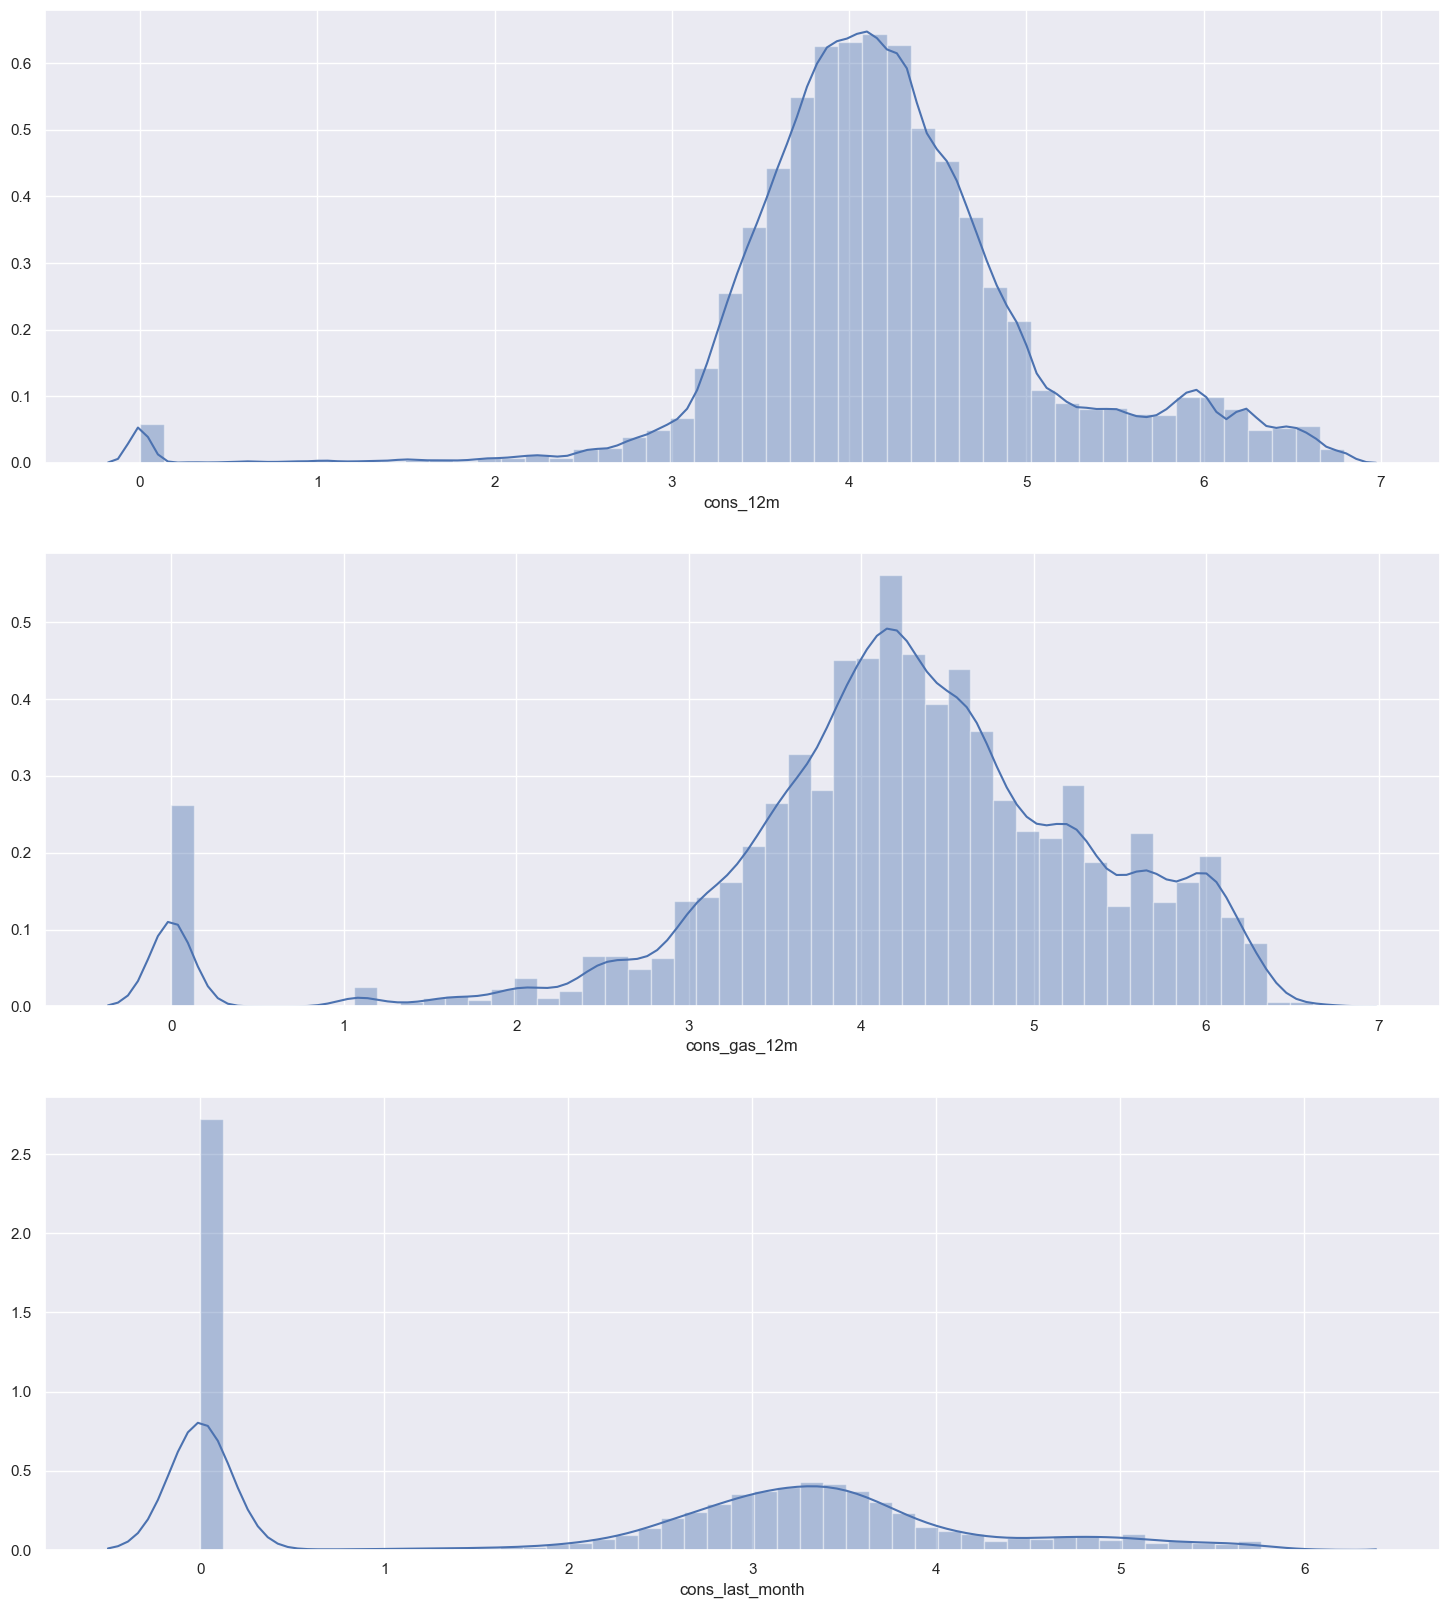

In [29]:
fig, axs = plt.subplots(nrows=3, figsize=(18, 20))
# Plot histograms
sns.distplot((df["cons_12m"].dropna()), ax=axs[0])
sns.distplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.distplot((df["cons_last_month"].dropna()), ax=axs[2])
plt.show()

### Correlations

In terms of creating new features and transforming existing ones, it is very much a trial and error situation that requires iteration. Once we train a predictive model we can see which features work and don't work, we will also know how predictive this set of features is. Based on this, we can come back to feature engineering to enhance our model. 

For now, we will leave feature engineering at this point. Another thing that is always useful to look at is how correlated all of the features are within your dataset.

This is important because it reveals the linear relationships between features. We want features to correlate with `churn`, as this will indicate that they are good predictors of it. However features that have a very high correlation can sometimes be suspicious. This is because 2 columns that have high correlation indicates that they may share a lot of the same information. One of the assumptions of any parametric predictive model (as stated earlier) is that all features must be independent.

For features to be independent, this means that each feature must have absolutely no dependence on any other feature. If two features are highly correlated and share similar information, this breaks this assumption. 

Ideally, you want a set of features that have 0 correlation with all of the independent variables (all features except our target variable) and a high correlation with the target variable (churn). However, this is very rarely the case and it is common to have a small degree of correlation between independent features.

So now let's look at how all the features within the model are correlated.

In [30]:
corr_matrix = df.corr()

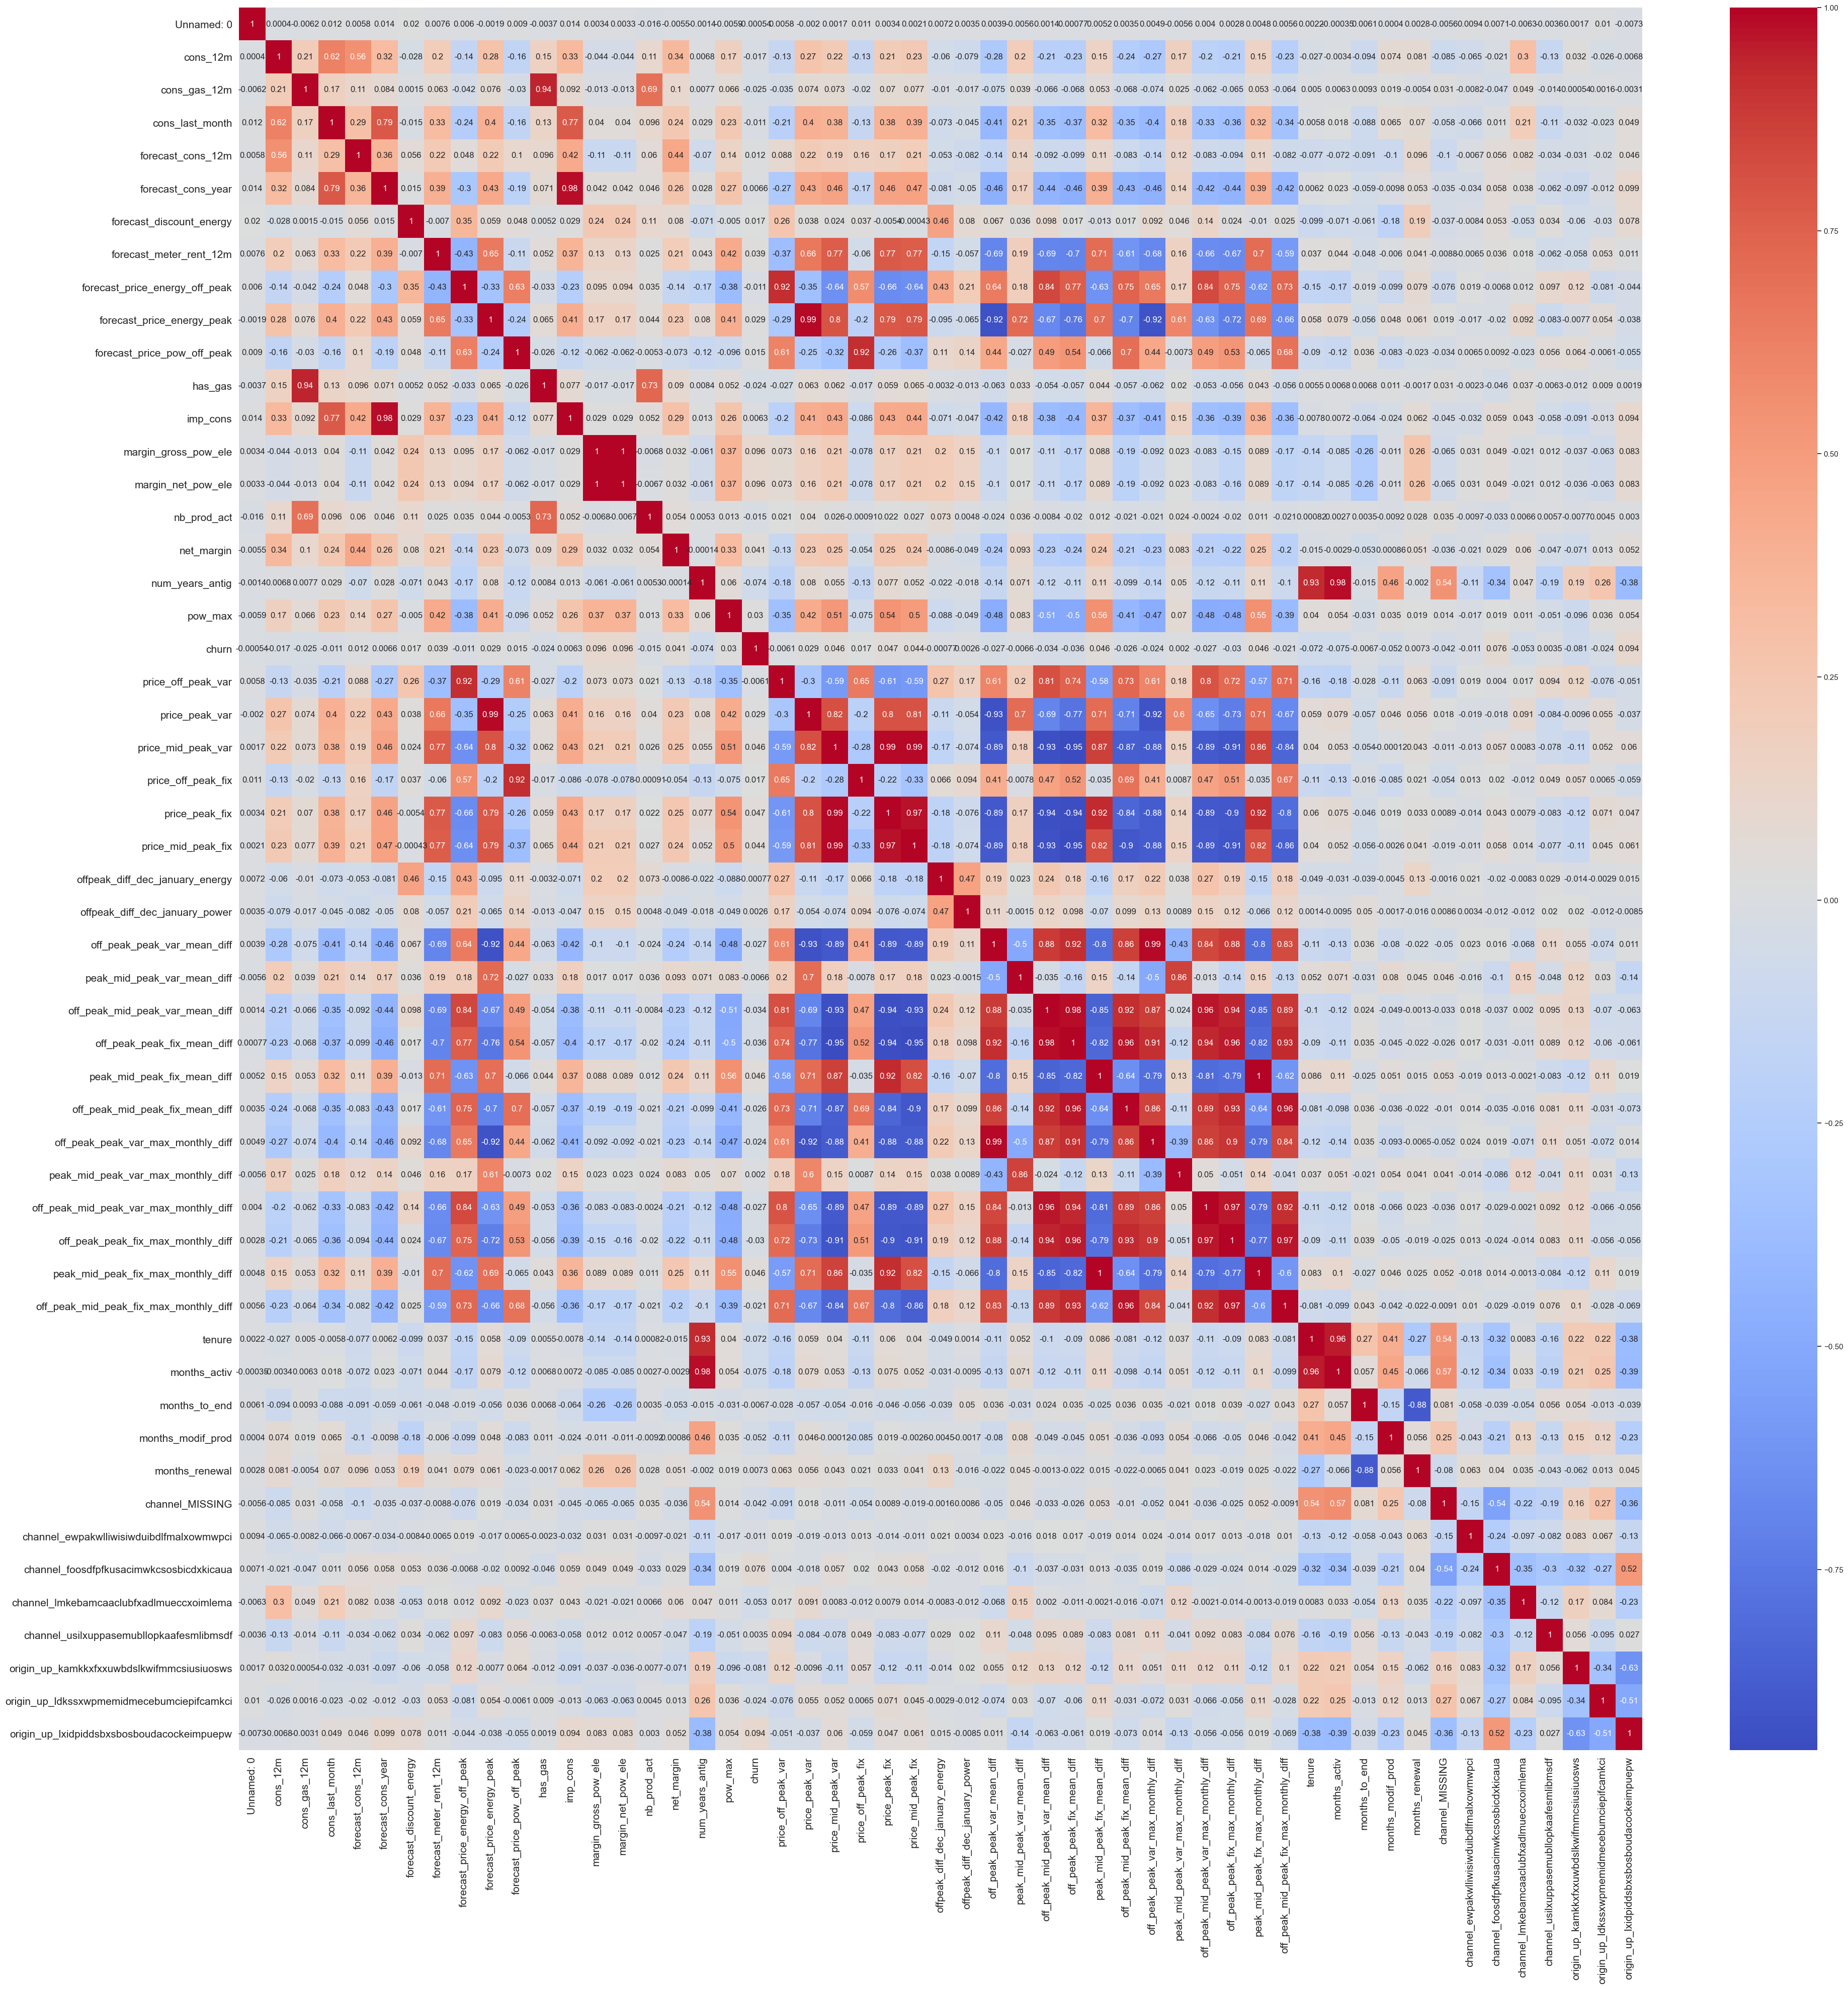

In [31]:
# Plot correlation
plt.figure(figsize=(45, 45))
sns.heatmap(
    corr_matrix, 
    cmap='coolwarm',
    xticklabels=corr_matrix.columns.values,
    yticklabels=corr_matrix.columns.values, 
    annot=True, 
    annot_kws={'size': 12}
)
# Axis ticks size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

I would consider removing highly correlated features that can introduce multicollinearity and therefore lead to instability and reduced interpretability of the model.

For now, I will remove two variables which exhibit a high correlation with other independent features.

After evaluating the performance of the ML model and obtaining feature importance in the next step, we'll come back and reconsider which features to remove.  

In [32]:
df = df.drop(columns=['num_years_antig', 'forecast_cons_year'])
df = df.drop(columns=['Unnamed: 0'])

df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0.0,4.739944,0.0,0.0,0.0,0.444045,0.114481,0.098142,40.606701,...,2,6,0,0,1,0,0,0,0,1
1,24011ae4ebbe3035111d65fa7c15bc57,0.0,4.739944,0.0,0.0,0.0,0.444045,0.114481,0.098142,40.606701,...,2,6,0,0,1,0,0,0,0,1
2,24011ae4ebbe3035111d65fa7c15bc57,0.0,4.739944,0.0,0.0,0.0,0.444045,0.114481,0.098142,40.606701,...,2,6,0,0,1,0,0,0,0,1
3,24011ae4ebbe3035111d65fa7c15bc57,0.0,4.739944,0.0,0.0,0.0,0.444045,0.114481,0.098142,40.606701,...,2,6,0,0,1,0,0,0,0,1
4,24011ae4ebbe3035111d65fa7c15bc57,0.0,4.739944,0.0,0.0,0.0,0.444045,0.114481,0.098142,40.606701,...,2,6,0,0,1,0,0,0,0,1


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175149 entries, 0 to 175148
Data columns (total 52 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   id                                          175149 non-null  object 
 1   cons_12m                                    175149 non-null  float64
 2   cons_gas_12m                                175149 non-null  float64
 3   cons_last_month                             175149 non-null  float64
 4   forecast_cons_12m                           175149 non-null  float64
 5   forecast_discount_energy                    175149 non-null  float64
 6   forecast_meter_rent_12m                     175149 non-null  float64
 7   forecast_price_energy_off_peak              175149 non-null  float64
 8   forecast_price_energy_peak                  175149 non-null  float64
 9   forecast_price_pow_off_peak                 175149 non-null  float64
 

In [34]:
df = df.drop(columns=['price_date'])

---

## 5. Modelling

We now have a dataset containing features that we have engineered and we are ready to start training a predictive model. Remember, we only need to focus on training a `Random Forest` classifier.

In [35]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

### Data sampling

The first thing we want to do is split our dataset into training and test samples. The reason why we do this, is so that we can simulate a real life situation by generating predictions for our test sample, without showing the predictive model these data points. This gives us the ability to see how well our model is able to generalise to new data, which is critical.

A typical % to dedicate to testing is between 20-30, for this example we will use a 80-20% split between train and test respectively.

In [36]:
# Make a copy of our data
train_df = df.copy()

# Separate target variable from independent variables
y = df['churn']
X = df.drop(columns=['id', 'churn'])
print(X.shape)
print(y.shape)

(175149, 49)
(175149,)


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(157634, 49)
(157634,)
(17515, 49)
(17515,)


In [38]:
y_train.value_counts(normalize=True)

0    0.902971
1    0.097029
Name: churn, dtype: float64

In [39]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install imbalanced-learn

### Oversampling for imbalanced classes

In [49]:
## Trouble shooting: ImportError fixed by restarting the Jupyter Notebook.
#from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

# Create a SMOTE object
#oversampler = SMOTE(sampling_strategy='auto', random_state=42)
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Fit and transform the dataset to perform oversampling
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train.ravel())

### Model training

Once again, we are using a `Random Forest` classifier in this example. A Random Forest sits within the category of `ensemble` algorithms because internally the `Forest` refers to a collection of `Decision Trees` which are tree-based learning algorithms. As the data scientist, you can control how large the forest is (that is, how many decision trees you want to include).

The reason why an `ensemble` algorithm is powerful is because of the laws of averaging, weak learners and the central limit theorem. If we take a single decision tree and give it a sample of data and some parameters, it will learn patterns from the data. It may be overfit or it may be underfit, but that is now our only hope, that single algorithm. 

With `ensemble` methods, instead of banking on 1 single trained model, we can train 1000's of decision trees, all using different splits of the data and learning different patterns. It would be like asking 1000 people to all learn how to code. You would end up with 1000 people with different answers, methods and styles! The weak learner notion applies here too, it has been found that if you train your learners not to overfit, but to learn weak patterns within the data and you have a lot of these weak learners, together they come together to form a highly predictive pool of knowledge! This is a real life application of many brains are better than 1.

Now instead of relying on 1 single decision tree for prediction, the random forest puts it to the overall views of the entire collection of decision trees. Some ensemble algorithms using a voting approach to decide which prediction is best, others using averaging. 

As we increase the number of learners, the idea is that the random forest's performance should converge to its best possible solution.

Some additional advantages of the random forest classifier include:

- The random forest uses a rule-based approach instead of a distance calculation and so features do not need to be scaled
- It is able to handle non-linear parameters better than linear based models

On the flip side, some disadvantages of the random forest classifier include:

- The computational power needed to train a random forest on a large dataset is high, since we need to build a whole ensemble of estimators.
- Training time can be longer due to the increased complexity and size of thee ensemble

In [50]:
model = RandomForestClassifier(
    n_estimators=500
)
#model.fit(X_resampled, y_resampled)
#model.fit(X_train, y_train)

Use cross-validation 

In [51]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [52]:
%%time

predictions = cross_val_predict(model, X_resampled, y_resampled, cv=cv, n_jobs=-1)

CPU times: user 158 ms, sys: 115 ms, total: 273 ms
Wall time: 2min 17s


The `scikit-learn` documentation: <https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html>, has a lot of information about the algorithm and the parameters that you can use when training a model.

For this example, I am using `n_estimators` = 500. This means that my random forest will consist of 500 decision trees. There are many more parameters that can be used to fine-tune within the random forest and finding the optimal combinations of parameters can be a manual task of exploration, trial and error, which will not be adjusted here but after the initial experiment.

### Evaluation

Now let's evaluate how well this trained model is able to predict the values of the test dataset.

We are going to use 3 metrics to evaluate performance:

- Accuracy = the ratio of correctly predicted observations to the total observations
- Precision = the ability of the classifier to not label a negative sample as positive
- Recall = the ability of the classifier to find all the positive samples
- F1 Score = a measure of predictive performance calculated from Precision and Recall.

The reason why we are using these metrics is because a simple accuracy is not always a good measure to use. 


In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_resampled, predictions)
precision = precision_score(y_resampled, predictions)
recall = recall_score(y_resampled, predictions)
f1 = f1_score(y_resampled, predictions)
conf_matrix = confusion_matrix(y_resampled, predictions)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
#print("Confusion Matrix:\n", conf_matrix)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [54]:
tn, fp, fn, tp = metrics.confusion_matrix(y_resampled, predictions).ravel()
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

True positives: 142339
False positives: 0
True negatives: 142339
False negatives: 0



At this point, a data scientist would go back to feature engineering to try and create more predictive features. The high scores may indicate data imbalance, issues in the trainning data, overfitting, etc. They may also experiment with optimising the parameters within the model to improve performance. For now, lets dive into understanding the model a little more.

### Model understanding

A simple way of understanding the results of a model is to look at feature importances. Feature importances indicate the importance of a feature within the predictive model, there are several ways to calculate feature importance, but with the Random Forest classifier, we're able to extract feature importances using the built-in method on the trained model. In the Random Forest case, the feature importance represents the number of times each feature is used for splitting across all trees.

In [56]:
model.fit(X_resampled, y_resampled)

RandomForestClassifier(n_estimators=500)

In [57]:
feature_importances = pd.DataFrame({
    'features': X_resampled.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()


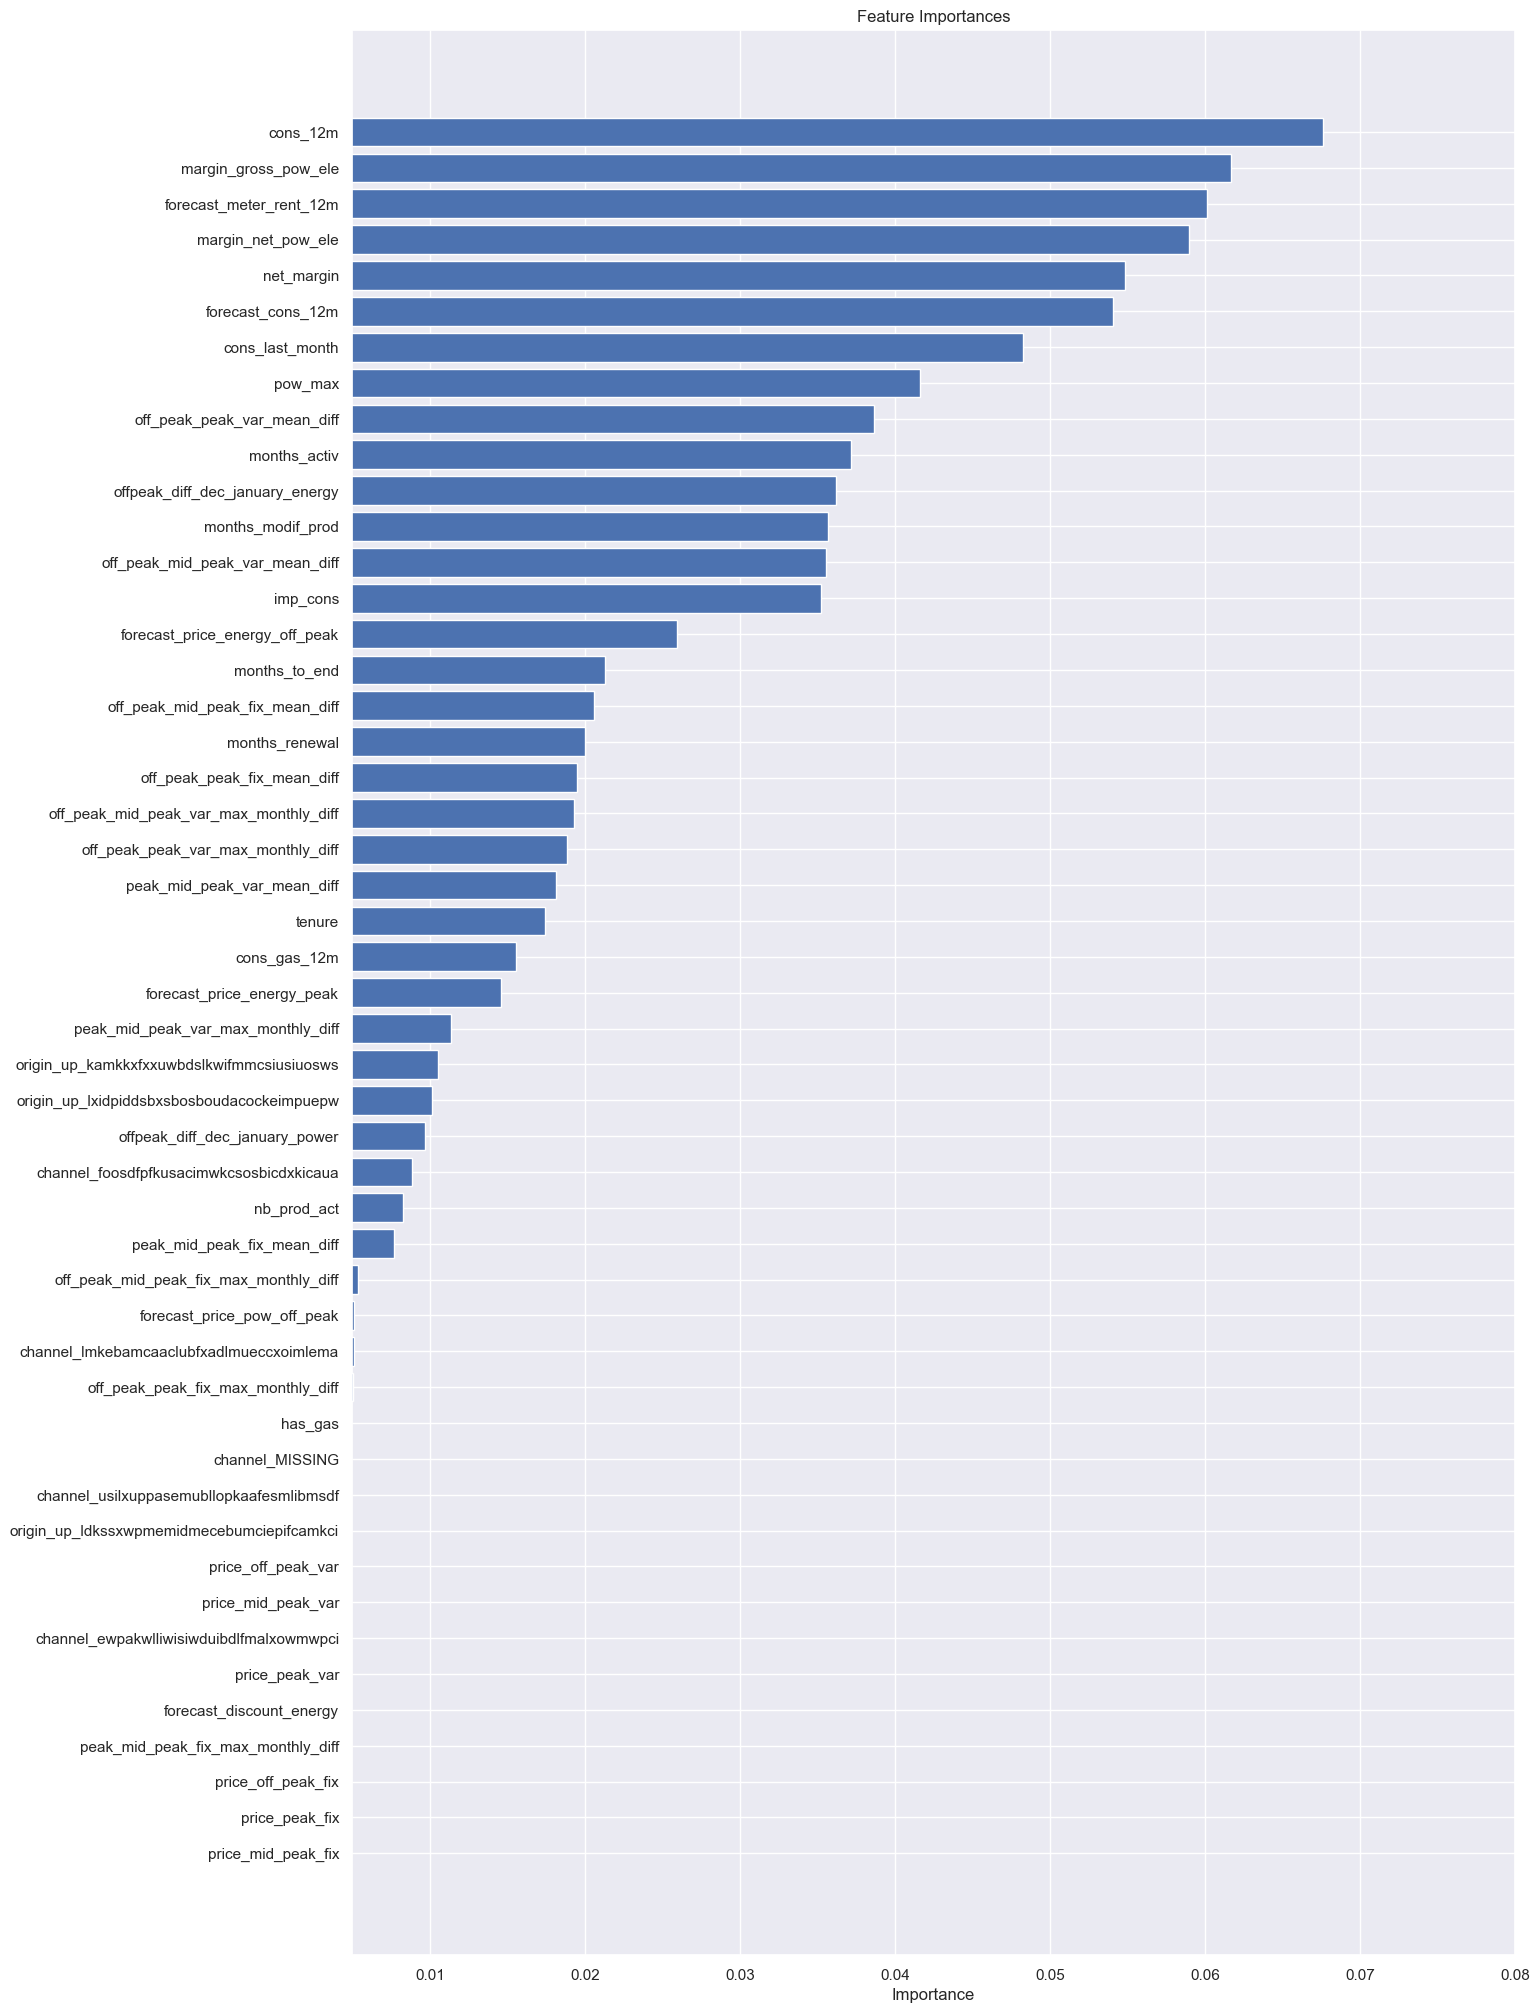

In [48]:
plt.figure(figsize=(15, 25))
plt.title('Feature Importances')
plt.barh(range(len(feature_importances)), feature_importances['importance'], color='b', align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'])
plt.xlabel('Importance')
plt.xlim(0.005, 0.08)
plt.show()

From this chart, we can observe the following points:

- Consumption over 12 months, Margin on power subscription, and Net margin are top drivers for churn in this model
- Time seems to be an influential factor, especially the number of months they have been active, their tenure and the number of months since they updated their contract
- The feature that our colleague recommended is in the top half in terms of how influential it is and some of the features built off the back of this actually outperform it
- Our price sensitivity features are scattered around but are not the main driver for a customer churning

The last observation is important because this relates back to our original hypothesis:

    > Is churn driven by the customers' price sensitivity?

Based on the output of the feature importances, it is not a main driver but it is a weak contributor. However, to arrive at a conclusive result, more experimentation is needed.

In [58]:
proba_predictions = model.predict_proba(X_test)
probabilities = proba_predictions[:, 1]
print(probabilities.sum())
print(len(probabilities))
print(len(X_test))

1710.8400000000001
17515
17515


In [59]:
X_test = X_test.reset_index()
X_test.drop(columns='index', inplace=True)

In [61]:
#X_test['churn'] = predictions.tolist()
X_test['churn_probability'] = probabilities.tolist()

In [62]:
X_test.to_csv('out_of_sample_data_with_predictions.csv')